In [1]:
import tensorflow as tf #... ne deluje v tensorflow 2.0
# GPU settings
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

!nvidia-smi
print(tf.__version__)

Sun Jan 12 23:32:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    31W / 250W |    265MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
# Inštalacija manjkajočih knjižnic 
#### !!! ob vsakem zagonu je potrebno preveriti, če je knjižnica inštalirana ###
!pip install SimpleITK
#!pip install tensorflow==2.0 # Zaenkrat ni potrebno, saj google še ni posodobil okolja na 2.0

     |████████████████████████████████| 42.5MB 72kB/s 


###***Uvoz knjižnic***
Izjema so knjižnice, ki jih nisem mogel uvoziti brez povezave na `/gdrive`. Te knjižnice so uvožene kasneje.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import tensorflow as tf
import time
import os
from os.path import join
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, BatchNormalization, Flatten, Reshape
from keras.models import Model, Sequential
from keras import backend as K
from keras import regularizers
from natsort import natsorted
from tqdm import tqdm

**Povezovanje z Google Drive**

Delovni direktorij je potrebno spremeniti v mapo `~/data` kjer se mora nahajati skripta amslib.py, `multisite-benchmark/` in `normal-subjects/`.

V mojem primeru je pot do direktorija: `My\ Drive/Colab\ Notebooks/data`.

In [4]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [5]:
%cd My\ Drive/Colab\ Notebooks/data

/gdrive/My Drive/Colab Notebooks/data


In [6]:
%pwd

'/gdrive/My Drive/Colab Notebooks/data'

###**Uvoz podatkov**

In [7]:
# Preštejem slike ge, philips in siemens
ge_PATH = './multisite-benchmark/ge'
philips_PATH = './multisite-benchmark/philips'
siemens_PATH = './normal-subjects/subjects'

ge_patients = natsorted(os.listdir(ge_PATH))
philips_patients = natsorted(os.listdir(philips_PATH))
siemens_patients = natsorted(os.listdir(siemens_PATH))

print('V mapi {:s} je {:d} datotek.'.format(ge_PATH, len(ge_patients)))
print('V mapi {:s} je {:d} datotek.'.format(philips_PATH, len(philips_patients)))
print('V mapi {:s} je {:d} podmap.'.format(siemens_PATH, len(siemens_patients)))

print(ge_patients)
print(philips_patients)
print(siemens_patients)

V mapi ./multisite-benchmark/ge je 58 datotek.
V mapi ./multisite-benchmark/philips je 56 datotek.
V mapi ./normal-subjects/subjects je 41 podmap.
['patient01-seg.nii.gz', 'patient01-t1w.nii.gz', 'patient02-seg.nii.gz', 'patient02-t1w.nii.gz', 'patient03-seg.nii.gz', 'patient03-t1w.nii.gz', 'patient04-seg.nii.gz', 'patient04-t1w.nii.gz', 'patient05-seg.nii.gz', 'patient05-t1w.nii.gz', 'patient06-seg.nii.gz', 'patient06-t1w.nii.gz', 'patient07-seg.nii.gz', 'patient07-t1w.nii.gz', 'patient08-seg.nii.gz', 'patient08-t1w.nii.gz', 'patient09-seg.nii.gz', 'patient09-t1w.nii.gz', 'patient10-seg.nii.gz', 'patient10-t1w.nii.gz', 'patient11-seg.nii.gz', 'patient11-t1w.nii.gz', 'patient12-seg.nii.gz', 'patient12-t1w.nii.gz', 'patient13-seg.nii.gz', 'patient13-t1w.nii.gz', 'patient14-seg.nii.gz', 'patient14-t1w.nii.gz', 'patient15-seg.nii.gz', 'patient15-t1w.nii.gz', 'patient16-seg.nii.gz', 'patient16-t1w.nii.gz', 'patient17-seg.nii.gz', 'patient17-t1w.nii.gz', 'patient18-seg.nii.gz', 'patient18-t

In [8]:
# Uvoz testne slike
filename = 'patient01-t1w.nii.gz'
DATA_PATH = philips_PATH
img = sitk.ReadImage(join(DATA_PATH,filename))
array = sitk.GetArrayFromImage(img)
print('Slika v {} je dimenzij: {}'.format(DATA_PATH,img.GetSize()))

Slika v ./multisite-benchmark/philips je dimenzij: (165, 352, 352)


###**Iskanje primernih rezin**
Prikazan je postopek določanja 2D rezin iz posamezne 3D slike za namene standardizacije učne množice.

27


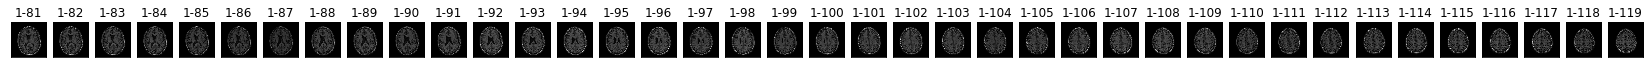

In [9]:
# # DOLOČIM na kateri rezini 3D slike bom učil avtoenkoder - za vsako sliko, zaradi biološke variabilnosti

# Izbira naprave
DATA_PATH = ge_PATH
siemens = False

# PREGLED REZIN vse slike naenkrat
chosen_ones = [1] # Kateri pacienti me zanimajo 
start = 80       # Na kateri rezini začnem

for patient in chosen_ones:
  if siemens == False:
    if patient < 10: filename = 'patient0'+str(patient)+'-t1w.nii.gz'
    else: filename = 'patient'+str(patient)+'-t1w.nii.gz'
    path2file = join(DATA_PATH,filename)
  else:
    filename = join(DATA_PATH,siemens_patients[patient])
    filename = join(filename,'pp_t1w.nii.gz')
    path2file = filename

  img = sitk.ReadImage(path2file)
  array = sitk.GetArrayFromImage(img)
  plt.figure(figsize=(30,4))
  for idx in range(1,40):
    img1 = array[start+idx,:,:]
    ax = plt.subplot(1,40,idx)
    plt.title(str(patient)+'-'+str(start+idx)) #patient num - slice num
    plt.imshow(img1,cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

########################### Indeksi izbranih rezin #############################
ge_idx = [90,89,98,99,91,99,85,98,88,89,104,90,98,96,98,93,90,105,95,93,99,97,83,92,95,99,94]
ph_idx = [236,226,224,227,223,222,230,233,230,226,223,234,225,222,231,232,235,235,234,233,202,228,233,231,227,229,205]
si_idx = [100,97,88,102,103,105,98,94,100,98,111,120,100,95,101,92,107,91,91,94,85,107,93,108,108,100,99]
################################################################################

In [10]:
import amslib
def get_slice(iImg,idx):
  # Pridobim eno rezino 3D slike
  array = sitk.GetArrayFromImage(iImg) 
  array = array[idx,:,:]
  array = array[np.newaxis]
  oImg = sitk.GetImageFromArray(array)
  return oImg

def extract_image(iImg, output_size=(128, 128), 
                        crop_size = (400, 400, 1), 
                        crop_origin = (50,70, 0),
                        interpolation_type=sitk.sitkLinear):
  #Prevzorčim in obrežem sliko
  new_spacing_mm = (crop_size[0] / output_size[0], crop_size[1] / output_size[1], 1)
  oImg = amslib.resample_image(sitk.RegionOfInterest(iImg, crop_size, crop_origin), 
                               spacing_mm = new_spacing_mm, 
                               inter_type=interpolation_type)
  return oImg

def stat_per_channel(values, stat_fcn, device='ge'):
  if device == 'ge':
    stat = stat_fcn(np.reshape(values, (values.shape[0]*ge_HEIGHT*ge_WIDTH, ge_CHANNELS)), axis=0)[:, np.newaxis]
  elif device == 'philips':
    stat = stat_fcn(np.reshape(values, (values.shape[0]*ph_HEIGHT*ph_WIDTH, ph_CHANNELS)), axis=0)[:, np.newaxis]
  elif device == 'siemens':
    stat = stat_fcn(np.reshape(values, (values.shape[0]*si_HEIGHT*si_WIDTH, si_CHANNELS)), axis=0)[:, np.newaxis]
  else:
    raise ValueError('Naprava ni znana!')
  return stat

################################ Uvoz slik #####################################
ge_data = []; ph_data = []; si_data = [] 

# Uvozim enako število pacientov za posamezno napravo - 18 v učni množici in 9 v testni
for i in tqdm(range(1,28)): 
  # Poimenovanje datotek za philips in ge naprave
  if i < 10:  
    patient_name = 'patient0'+str(i)+'-t1w.nii.gz'
  else:
    patient_name = 'patient'+str(i)+'-t1w.nii.gz'

  # Preberem slike  
  t1_ge = get_slice(sitk.ReadImage(join(ge_PATH,patient_name)),ge_idx[i-1])
  t1_ph = get_slice(sitk.ReadImage(join(philips_PATH,patient_name)),ph_idx[i-1])
  p2f = join(siemens_PATH,siemens_patients[0])
  t1_si = get_slice(sitk.ReadImage(join(p2f,'pp_t1w.nii.gz')),si_idx[i-1])        

  # Obrezovanje in prevzorčenje slik
  t1_ge = extract_image(t1_ge,crop_size=(400,400,1),crop_origin=(50,70,0))
  t1_ph = extract_image(t1_ph,crop_size=(160,260,1),crop_origin=(0,60,0))
  t1_si = extract_image(t1_si,crop_size=(154,154,1),crop_origin=(0,20,0))

  ge_data.append({'t1':t1_ge})
  ph_data.append({'t1':t1_ph})
  si_data.append({'t1':t1_si})

####################### Zložim vse slike v 3D polje ############################
ge_array = np.dstack([np.squeeze(sitk.GetArrayFromImage(data['t1'])) for data in ge_data])
print('\nVelikost GE polja: {}'.format(ge_array.shape))
ge_array = np.transpose(ge_array,(2,0,1))
print('Velikost preoblikovanega GE polja: {}'.format(ge_array.shape))

ph_array = np.dstack([np.squeeze(sitk.GetArrayFromImage(data['t1'])) for data in ph_data])
print('\nVelikost Philips polja: {}'.format(ph_array.shape))
ph_array = np.transpose(ph_array,(2,0,1))
print('Velikost preoblikovanega Philips polja: {}'.format(ph_array.shape))

si_array = np.dstack([np.squeeze(sitk.GetArrayFromImage(data['t1'])) for data in si_data])
print('\nVelikost Siemens polja: {}'.format(si_array.shape))
si_array = np.transpose(si_array,(2,0,1))
print('Velikost preoblikovanega Siemens polja: {}'.format(si_array.shape))

#################### Preoblikovanje v keras format #############################
print('\nKeras format: {}'.format(K.image_data_format()))

# ustvari podatke za učenje in test
if K.image_data_format() == 'channels_first':
    ge_karray = ge_array[:, np.newaxis, :, :]
    ph_karray = ph_array[:, np.newaxis, :, :]
    si_karray = si_array[:, np.newaxis, :, :]
else:
    ge_karray = ge_array[:, :, :, np.newaxis]
    ph_karray = ph_array[:, :, :, np.newaxis]
    si_karray = si_array[:, :, :, np.newaxis]
print('Velikost polja GE slik {}'.format(ge_karray.shape))
print('Velikost polja Philips slik {}'.format(ph_karray.shape))
print('Velikost polja Siemens slik {}'.format(si_karray.shape))

################### Normalizacija sivinskih vrednosti ##########################
# Preberi velikosti slik
_, ge_HEIGHT, ge_WIDTH, ge_CHANNELS = ge_karray.shape
_, ph_HEIGHT, ph_WIDTH, ph_CHANNELS = ph_karray.shape
_, si_HEIGHT, si_WIDTH, si_CHANNELS = si_karray.shape

# Izračunaj mejne sivinske vrednosti preko vseh slik (min, max)


min_ge_karray, max_ge_karray = stat_per_channel(ge_karray, np.min), stat_per_channel(ge_karray, np.max)
min_ph_karray, max_ph_karray = stat_per_channel(ph_karray, np.min), stat_per_channel(ph_karray, np.max)
min_si_karray, max_si_karray = stat_per_channel(si_karray, np.min), stat_per_channel(si_karray, np.max)
print('\nObmočje sivinskih vrednosti pred normalizacijo:')
print('\tge_min: {}'.format(min_ge_karray.flatten()))
print('\tge_max:{}'.format(max_ge_karray.flatten()))
print('\tph_min: {}'.format(min_ph_karray.flatten()))
print('\tph_max:{}'.format(max_ph_karray.flatten()))
print('\tsi_min: {}'.format(min_si_karray.flatten()))
print('\tsi_max:{}'.format(max_si_karray.flatten()))

min_ge_karray = np.reshape(min_ge_karray, (1, 1, 1, ge_CHANNELS))
max_ge_karray = np.reshape(max_ge_karray, (1, 1, 1, ge_CHANNELS))
min_ph_karray = np.reshape(min_ph_karray, (1, 1, 1, ph_CHANNELS))
max_ph_karray = np.reshape(max_ph_karray, (1, 1, 1, ph_CHANNELS))
min_si_karray = np.reshape(min_si_karray, (1, 1, 1, si_CHANNELS))
max_si_karray = np.reshape(max_si_karray, (1, 1, 1, si_CHANNELS))

# Normaliziraj vhodne slike 
ge = (ge_karray - min_ge_karray) / (max_ge_karray - min_ge_karray)
ph = (ph_karray - min_ph_karray) / (max_ph_karray - min_ph_karray)
si = (si_karray - min_si_karray) / (max_si_karray - min_si_karray)

min_ge_karray, max_ge_karray = stat_per_channel(ge, np.min), stat_per_channel(ge, np.max)
min_ph_karray, max_ph_karray = stat_per_channel(ph, np.min), stat_per_channel(ph, np.max)
min_si_karray, max_si_karray = stat_per_channel(si, np.min), stat_per_channel(si, np.max)

print('Območje sivinskih vrednosti po normalizaciji:')
print('\tge_min: {}'.format(min_ge_karray.flatten()))
print('\tge_max:{}'.format(max_ge_karray.flatten()))
print('\tph_min: {}'.format(min_ph_karray.flatten()))
print('\tph_max:{}'.format(max_ph_karray.flatten()))
print('\tsi_min: {}'.format(min_si_karray.flatten()))
print('\tsi_max:{}'.format(max_si_karray.flatten()))

100%|██████████| 27/27 [02:06<00:00,  4.77s/it]


Velikost GE polja: (128, 128, 27)
Velikost preoblikovanega GE polja: (27, 128, 128)

Velikost Philips polja: (128, 128, 27)
Velikost preoblikovanega Philips polja: (27, 128, 128)

Velikost Siemens polja: (128, 128, 27)
Velikost preoblikovanega Siemens polja: (27, 128, 128)

Keras format: channels_last
Velikost polja GE slik (27, 128, 128, 1)
Velikost polja Philips slik (27, 128, 128, 1)
Velikost polja Siemens slik (27, 128, 128, 1)

Območje sivinskih vrednosti pred normalizacijo:
	ge_min: [0.]
	ge_max:[8219.094]
	ph_min: [0.]
	ph_max:[2142.625]
	si_min: [-6.8223743]
	si_max:[727.9461]
Območje sivinskih vrednosti po normalizaciji:
	ge_min: [0.]
	ge_max:[1.]
	ph_min: [0.]
	ph_max:[1.]
	si_min: [0.]
	si_max:[1.]


###**Priprava učne in testne množice**

Učna množica  so prvič le `ge/` slike drugič pa kombinacija `ge/` in `philips/`, siemens/ je v obeh primerih le testna množica. Učno množico sestavim iz 2/3 množice slik. Podatke preoblikujemo na način, da jih lahko obdelamo z avtoenkoderjem.


In [388]:
# Določitev množic za križno testiranje
################################# test 1 #######################################
x_train1a = ge[0:18,:,:,:]; 
ge_test1a = ge[18:27,:,:,:]; ph_test1a = ph[18:27,:,:,:]; si_test1a = si[18:27,:,:,:]

x_train1b = np.append(ge[0:9,:,:,:],ge[18:27,:,:,:],axis = 0); 
ge_test1b = ge[9:18,:,:,:]; ph_test1b = ph[9:18,:,:,:]; si_test1b = si[9:18,:,:,:]

x_train1c = ge[9:27,:,:,:]; 
ge_test1c = ge[0:9,:,:,:]; ph_test1c = ph[0:9,:,:,:]; si_test1c = si[0:9,:,:,:]

################################# test 2 #######################################
x_train2a = np.append(ge[0:18,:,:,:],ph[0:18,:,:,:],axis = 0); 
ge_test2a = ge[18:27,:,:,:]; ph_test2a = ph[18:27,:,:,:]; si_test2a = si[18:27,:,:,:]

tmp_ge = np.append(ge[0:9,:,:,:],ge[18:27,:,:,:],axis = 0); 
tmp_ph = np.append(ph[0:9,:,:,:],ph[18:27,:,:,:],axis = 0); 
x_train2b = np.append(tmp_ge,tmp_ph,axis = 0); 
ge_test2b = ge[9:18,:,:,:]; ph_test2b = ph[9:18,:,:,:]; si_test2b = si[9:18,:,:,:]

x_train2c = np.append(ge[9:27,:,:,:],ph[9:27,:,:,:],axis = 0); 
ge_test2c = ge[0:9,:,:,:]; ph_test2c = ph[0:9,:,:,:]; si_test2c = si[0:9,:,:,:]

################################################################################
print('Učna množica za test 1: {}'.format(x_train1a.shape))
print('Validacijska množica za test 1: {}'.format(ge_test1a.shape))
print('Učna množica za test 2: {}'.format(x_train2a.shape))
print('Validacijska množica za test 2: {}'.format(ge_test2a.shape))

Učna množica za test 1: (18, 128, 128, 1)
Validacijska množica za test 1: (9, 128, 128, 1)
Učna množica za test 2: (36, 128, 128, 1)
Validacijska množica za test 2: (9, 128, 128, 1)


0.0 0.96982384
(9, 128, 128, 1)


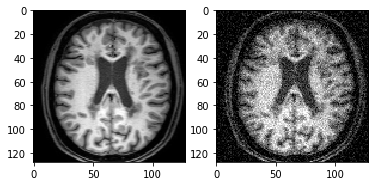

In [389]:
# Preoblikovanje podatkov
def reshape_data(in_train, in_test_ge, in_test_ph, in_test_si):
  out_train = in_train.reshape((len(in_train), np.prod(in_train.shape[1:])))
  out_test_ge = in_test_ge.reshape((len(in_test_ge), np.prod(in_test_ge.shape[1:])))
  out_test_ph = in_test_ph.reshape((len(in_test_ph), np.prod(in_test_ph.shape[1:])))
  out_test_si = in_test_si.reshape((len(in_test_si), np.prod(in_test_si.shape[1:])))
  return out_train, out_test_ge, out_test_ph, out_test_si

def add_noise(iImg, noise_factor=0.1):
    noise = np.random.randn(*iImg.shape) * noise_factor
    oImg = iImg + noise
    oImg = oImg.clip(0., 1.)
    return oImg

def add4noise(i1, i2, i3, i4, noise_factor=0.1):
    o1 = add_noise(i1,noise_factor)
    o2 = add_noise(i2,noise_factor)
    o3 = add_noise(i3,noise_factor)
    o4 = add_noise(i4,noise_factor)
    return o1, o2, o3, o4

# Reshape data (128,128,1) to (16384,) - uporabno samo za preprost avtoenkoder
x_train_1a, ge_test_1a, ph_test_1a, si_test_1a = reshape_data(x_train1a, ge_test1a, ph_test1a, si_test1a)
x_train_1b, ge_test_1b, ph_test_1b, si_test_1b = reshape_data(x_train1b, ge_test1b, ph_test1b, si_test1b)
x_train_1c, ge_test_1c, ph_test_1c, si_test_1c = reshape_data(x_train1c, ge_test1c, ph_test1c, si_test1c)
x_train_2a, ge_test_2a, ph_test_2a, si_test_2a = reshape_data(x_train2a, ge_test2a, ph_test2a, si_test2a)
x_train_2b, ge_test_2b, ph_test_2b, si_test_2b = reshape_data(x_train2b, ge_test2b, ph_test2b, si_test2b)
x_train_2c, ge_test_2c, ph_test_2c, si_test_2c = reshape_data(x_train2c, ge_test2c, ph_test2c, si_test2c)

# Add noise to (128,128,1)
n_factor = 0.1
x_train1a_n, ge_test1a_n, ph_test1a_n, si_test1a_n = add4noise(x_train1a, ge_test1a, ph_test1a, si_test1a, n_factor)
x_train1b_n, ge_test1b_n, ph_test1b_n, si_test1b_n = add4noise(x_train1b, ge_test1b, ph_test1b, si_test1b, n_factor)
x_train1c_n, ge_test1c_n, ph_test1c_n, si_test1c_n = add4noise(x_train1c, ge_test1c, ph_test1c, si_test1c, n_factor)
x_train2a_n, ge_test2a_n, ph_test2a_n, si_test2a_n = add4noise(x_train2a, ge_test2a, ph_test2a, si_test2a, n_factor)
x_train2b_n, ge_test2b_n, ph_test2b_n, si_test2b_n = add4noise(x_train2b, ge_test2b, ph_test2b, si_test2b, n_factor)
x_train2c_n, ge_test2c_n, ph_test2c_n, si_test2c_n = add4noise(x_train2c, ge_test2c, ph_test2c, si_test2c, n_factor)

#Primerjava s sliko brez šuma
array = ph_test1a[0,:,:,0]
x = add_noise(array,n_factor)

plt.figure()
plt.subplot(121)
plt.imshow(array,cmap='gray')
plt.subplot(122)
plt.imshow(x,cmap='gray')
print(np.min(array),np.max(array))
print(ph_test1a.shape)

###**Definicija avtoenkoderja**

Definiram funkcijo avtoenkoder in funkcijo za interpolacijo slik.

In [0]:
# Avtoenkoder
def build_conv_autoencoder(kernel = 3):
  input_img = Input(shape=(128, 128, 1))  # adapt this if using `channels_first` image data format  

  #encoder
  x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
  x = MaxPooling2D((2, 2), padding='same')(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  encoded = MaxPooling2D((2, 2), padding='same')(x)

  #decoder
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
  x = UpSampling2D((2, 2))(x)
  decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

  autoencoder = Model(input_img, decoded)
  autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

  return autoencoder

# Izboljšava kvalitete slike
def upsample(iImg, up_step=(2,2), interp='bilinear'):
  # Notri gre 4D zbirka slik
  input_image_shape = iImg.shape

  # Build model
  model = Sequential()
  model.add(UpSampling2D(up_step, input_shape=input_image_shape[1:], interpolation=interp))

  oImg = model.predict(iImg)
  return oImg

# Prikaz rezultatov
def plot_out(model, test_data, title, n = 9, conv = True):
  # Test specific autoencoder
  out = model.predict(test_data); 
  out = upsample(out,up_step=(4,4))

  fig = plt.figure(figsize=(20, 4));  fig.suptitle(title)
  for i in range(n): # n določa koliko slik želimo prikazati
    if conv == True:
      iData = test_data[i,:,:,0]
      oData = out[i,:,:,0]
    else:
      iData = test_data[i].reshape(128, 128)
      oData = out[i].reshape(128,128)

    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(iData)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(oData)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

def plot1(model,test_data,up_step=(2,2),n=9,title='upsampled'):
  out = model.predict(test_data); out_upsampled = upsample(out,up_step=up_step)
  fig = plt.figure(figsize=(20, 4));  fig.suptitle(title)
  for i in range(n):
    oUp = out_upsampled[i,:,:,0]

    plt.subplot(1,n,i+1)
    plt.imshow(oUp)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

### **Build tunnel for Tensorboard**

In [383]:
# Download ngrok to Colab
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2020-01-13 04:50:59--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.20.119.24, 34.235.253.190, 52.5.84.255, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.20.119.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  16.1MB/s    in 0.8s    

2020-01-13 04:51:00 (16.1 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [391]:
# Fire up tensorboard
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

# Tunnel TensorBoard port 6006 out into the world
get_ipython().system_raw('./ngrok http 6006 &')

# Get public URL to access TensorBoard
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

# Definiram sklic za učenje
from keras.callbacks import TensorBoard
tbCallBack = TensorBoard(log_dir='./log', histogram_freq=1,
                         write_graph=True,
                         write_grads=True,
                         batch_size=18,
                         write_images=True)

https://90071f9f.ngrok.io


###**Učenje**
Naučene modele naložim v celici nižje.

In [395]:
# #Križno testiranje
# AE1a = build_conv_autoencoder()
# AE1b = build_conv_autoencoder()
# AE1c = build_conv_autoencoder()
# AE2a = build_conv_autoencoder()
# AE2b = build_conv_autoencoder()
# AE2c = build_conv_autoencoder()
# AE1a.summary()

# ################################# TEST 1 #######################################
# more = 2
# batch1 = 18;

# print('############# TEST 1 batch_size =',batch1,'#############')

# AE1a.fit(x_train1a_n,x_train1a,
#         epochs=200,
#         batch_size=batch,
#         shuffle=True,
#         validation_data=(ge_test1a_n,ge_test1a),)
# AE1b.fit(x_train1b_n,x_train1b,
#         epochs=200,
#         batch_size=batch,
#         shuffle=True,
#         validation_data=(ge_test1b_n,ge_test1b))
# AE1c.fit(x_train1c_n,x_train1c,
#         epochs=200,
#         batch_size=batch,
#         shuffle=True,
#         validation_data=(ge_test1c_n,ge_test1c))

# ################################# TEST 2 #######################################
# print('############# TEST 2 batch_size =',batch2,'#############')

# AE2a.fit(x_train2a_n,x_train2a,
#         epochs=200,
#         batch_size=batch,
#         shuffle=True,
#         validation_data=(ge_test2a_n,ge_test2a))
# AE2b.fit(x_train2b_n,x_train2b,
#         epochs=200,
#         batch_size=batch,
#         shuffle=True,
#         validation_data=(ge_test2b_n,ge_test2b))
# AE2c.fit(x_train2c_n,x_train2c,
#         epochs=200,
#         batch_size=batch,
#         shuffle=True,
#         validation_data=(ge_test2c_n,ge_test2c))

Model: "model_247"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_252 (InputLayer)       (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_1150 (Conv2D)         (None, 128, 128, 64)      640       
_________________________________________________________________
max_pooling2d_514 (MaxPoolin (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1151 (Conv2D)         (None, 64, 64, 32)        18464     
_________________________________________________________________
max_pooling2d_515 (MaxPoolin (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1152 (Conv2D)         (None, 32, 32, 32)        9248      
_________________________________________________________________
up_sampling2d_456 (UpSamplin (None, 64, 64, 32)        0 

In [0]:
# SHRANJEVANJE MODELOV
import h5py
from keras.models import load_model
# AE1a.save('AE1a.h5')
# AE1b.save('AE1b.h5')
# AE1c.save('AE1c.h5')
# AE2a.save('AE2a.h5')
# AE2b.save('AE2b.h5')
# AE2c.save('AE2c.h5')

# NALAGANJE MODELOV
del AE1a, AE1b, AE1c, AE2a, AE2b, AE2c # Izbris obstoječih modelov
AE1a = load_model('AE1a.h5')
AE1b = load_model('AE1a.h5')
AE1c = load_model('AE1a.h5')
AE2a = load_model('AE1a.h5')
AE2b = load_model('AE1a.h5')
AE2c = load_model('AE1a.h5')

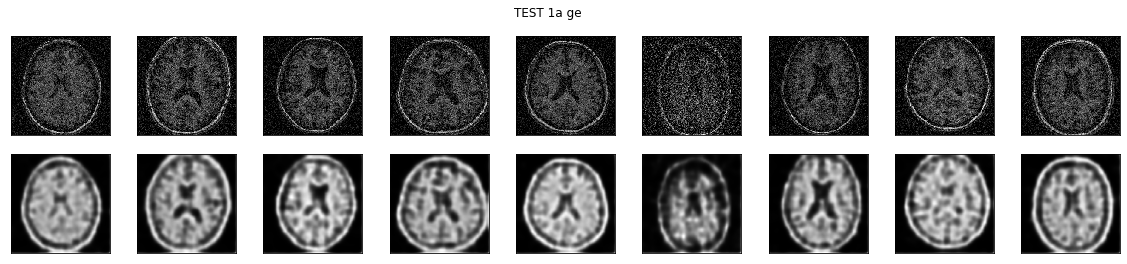

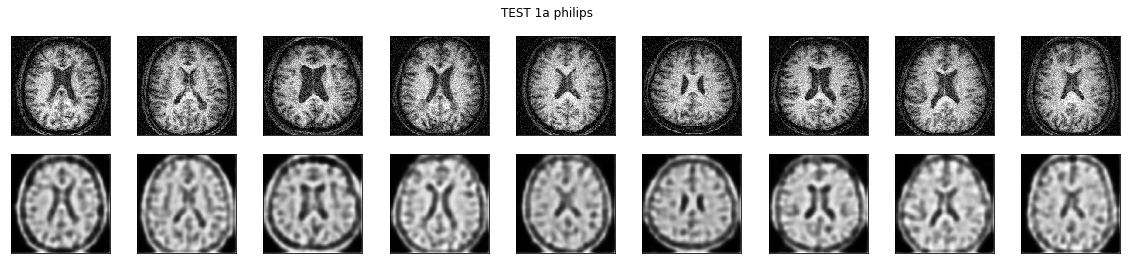

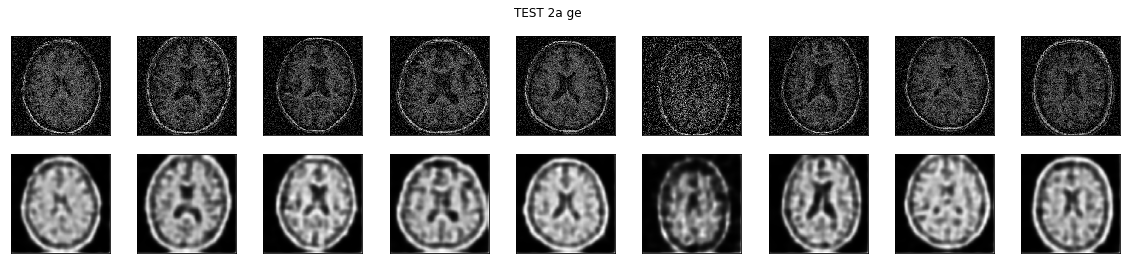

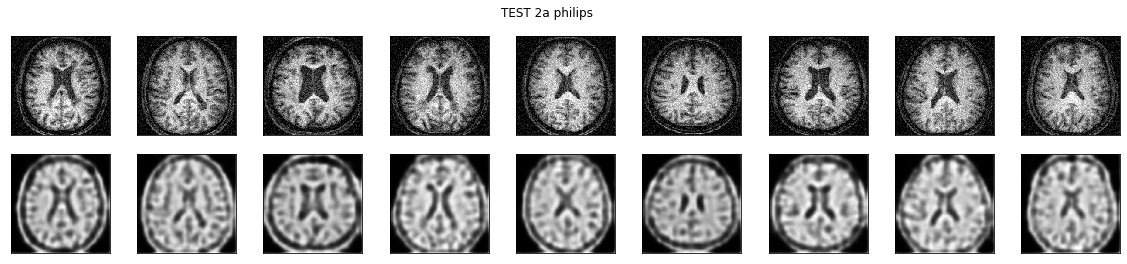

In [484]:
# Prikaz rezultatov testov 1 in 2
plot_out(AE1a,ge_test1a_n,n = 9, title = 'TEST 1a ge')
plot_out(AE1a,ph_test1a_n,n = 9, title = 'TEST 1a philips')
plot_out(AE2a,ge_test2a_n,n = 9, title = 'TEST 2a ge')
plot_out(AE2a,ph_test2a_n,n = 9, title = 'TEST 2a philips')


##**Določitev metrik**
Kakovost izhoda avtoenkoderja ocenim z metrikama PSNR in SSIM.

In [464]:
def mean(a,b,c):  #a,b,c are vector metrics for specific test
  return (a + b + c)/3

################################# TEST 1 #######################################
o1a_ge = AE1a.predict(ge_test1a_n); o1a_ph = AE1a.predict(ph_test1a_n); o1a_si = AE1a.predict(si_test1a_n)
o1b_ge = AE1b.predict(ge_test1b_n); o1b_ph = AE1b.predict(ph_test1b_n); o1b_si = AE1b.predict(si_test1b_n)
o1c_ge = AE1c.predict(ge_test1c_n); o1c_ph = AE1c.predict(ph_test1c_n); o1c_si = AE1c.predict(si_test1c_n)

# Vse pretvorim v TensorFlow format
# Vhod AE
ge_1a_n = tf.convert_to_tensor(ge_test1a_n,np.float32); ph_1a_n = tf.convert_to_tensor(ph_test1a_n,np.float32); si_1a_n = tf.convert_to_tensor(si_test1a_n,np.float32)
ge_1b_n = tf.convert_to_tensor(ge_test1b_n,np.float32); ph_1b_n = tf.convert_to_tensor(ph_test1b_n,np.float32); si_1b_n = tf.convert_to_tensor(si_test1b_n,np.float32)
ge_1c_n = tf.convert_to_tensor(ge_test1c_n,np.float32); ph_1c_n = tf.convert_to_tensor(ph_test1c_n,np.float32); si_1c_n = tf.convert_to_tensor(si_test1c_n,np.float32)
# Izhod AE
o1a_ge = tf.convert_to_tensor(o1a_ge,np.float32); o1a_ph = tf.convert_to_tensor(o1a_ph,np.float32); o1a_si = tf.convert_to_tensor(o1a_si,np.float32);
o1b_ge = tf.convert_to_tensor(o1b_ge,np.float32); o1b_ph = tf.convert_to_tensor(o1b_ph,np.float32); o1b_si = tf.convert_to_tensor(o1b_si,np.float32);
o1c_ge = tf.convert_to_tensor(o1c_ge,np.float32); o1c_ph = tf.convert_to_tensor(o1c_ph,np.float32); o1c_si = tf.convert_to_tensor(o1c_si,np.float32); 

# Spremenljivke, ki jih rabim za izračun metrik shranim v slovar
var = {'o1a_ge':o1a_ge, 'o1b_ge':o1b_ge, 'o1c_ge':o1c_ge,'ge_1a_n':ge_1a_n, 'ph_1a_n':ph_1a_n, 'si_1a_n':si_1a_n,
       'o1a_ph':o1a_ph, 'o1b_ph':o1b_ph, 'o1c_ph':o1c_ph,'ge_1b_n':ge_1b_n, 'ph_1b_n':ph_1b_n, 'si_1b_n':si_1b_n,
       'o1a_si':o1a_si, 'o1b_si':o1b_si, 'o1c_si':o1c_si,'ge_1c_n':ge_1c_n, 'ph_1c_n':ph_1c_n, 'si_1c_n':si_1c_n} 

devices = ['ge','ph','si']
PSNR_1 = []; SSIM_1 = []
for dev in tqdm(devices): # Izračunam za vsako napravo
  out_a = 'o1a_' + dev; out_b = 'o1b_' + dev; out_c = 'o1c_' + dev
  in_a = dev + '_1a_n'; in_b = dev + '_1b_n'; in_c = dev + '_1c_n';

  #psnr 
  a = tf.Session().run(tf.image.psnr(var[in_a],var[out_a],max_val=1.0))
  b = tf.Session().run(tf.image.psnr(var[in_b],var[out_b],max_val=1.0))
  c = tf.Session().run(tf.image.psnr(var[in_c],var[out_c],max_val=1.0))
  psnr = mean(a,b,c)
  PSNR_1.append(psnr)

  #ssim
  a = tf.Session().run(tf.image.ssim(var[in_a],var[out_a],max_val=1.0))
  b = tf.Session().run(tf.image.ssim(var[in_b],var[out_b],max_val=1.0))
  c = tf.Session().run(tf.image.ssim(var[in_c],var[out_c],max_val=1.0))
  ssim = mean(a,b,c)
  SSIM_1.append(ssim)
print(PSNR_1,'\n\n',SSIM_1)
################################################################################

100%|██████████| 3/3 [01:37<00:00, 32.34s/it]

[array([19.474997, 19.27477 , 19.067642, 19.023687, 19.628693, 19.834593,
       19.394297, 19.214468, 19.359072], dtype=float32), array([11.344237 , 11.1064825, 11.652291 , 11.039645 , 11.440158 ,
       11.410133 , 11.111783 , 11.257686 , 11.264659 ], dtype=float32), array([14.836661, 14.803542, 14.981316, 14.85672 , 14.827668, 14.816358,
       14.851409, 14.866038, 14.852351], dtype=float32)] 

 [array([0.18985188, 0.2111728 , 0.1991607 , 0.19890831, 0.18833251,
       0.1811812 , 0.18022972, 0.19301455, 0.20220159], dtype=float32), array([0.17821197, 0.16549855, 0.18209112, 0.17171301, 0.17750376,
       0.17114598, 0.17607687, 0.16111849, 0.16799931], dtype=float32), array([0.14470272, 0.14134912, 0.14312826, 0.14261802, 0.14537412,
       0.14394073, 0.14341335, 0.13987873, 0.14193785], dtype=float32)]


In [465]:
################################# TEST 2 #######################################
o2a_ge = AE2a.predict(ge_test2a_n); o2a_ph = AE2a.predict(ph_test2a_n); o2a_si = AE2a.predict(si_test2a_n)
o2b_ge = AE2b.predict(ge_test2b_n); o2b_ph = AE2b.predict(ph_test2b_n); o2b_si = AE2b.predict(si_test2b_n)
o2c_ge = AE2c.predict(ge_test2c_n); o2c_ph = AE2c.predict(ph_test2c_n); o2c_si = AE2c.predict(si_test2c_n)

# Vse pretvorim v TensorFlow format
# Vhod AE
ge_2a_n = tf.convert_to_tensor(ge_test2a_n,np.float32); ph_2a_n = tf.convert_to_tensor(ph_test2a_n,np.float32); si_2a_n = tf.convert_to_tensor(si_test2a_n,np.float32)
ge_2b_n = tf.convert_to_tensor(ge_test2b_n,np.float32); ph_2b_n = tf.convert_to_tensor(ph_test2b_n,np.float32); si_2b_n = tf.convert_to_tensor(si_test2b_n,np.float32)
ge_2c_n = tf.convert_to_tensor(ge_test2c_n,np.float32); ph_2c_n = tf.convert_to_tensor(ph_test2c_n,np.float32); si_2c_n = tf.convert_to_tensor(si_test2c_n,np.float32)
# Izhod AE
o2a_ge = tf.convert_to_tensor(o2a_ge,np.float32); o2a_ph = tf.convert_to_tensor(o2a_ph,np.float32); o2a_si = tf.convert_to_tensor(o2a_si,np.float32);
o2b_ge = tf.convert_to_tensor(o2b_ge,np.float32); o2b_ph = tf.convert_to_tensor(o2b_ph,np.float32); o2b_si = tf.convert_to_tensor(o2b_si,np.float32);
o2c_ge = tf.convert_to_tensor(o2c_ge,np.float32); o2c_ph = tf.convert_to_tensor(o2c_ph,np.float32); o2c_si = tf.convert_to_tensor(o2c_si,np.float32); 

# Spremenljivke, ki jih rabim za izračun metrik shranim v slovar
var = {'o2a_ge':o2a_ge, 'o2b_ge':o2b_ge, 'o2c_ge':o2c_ge,'ge_2a_n':ge_2a_n, 'ph_2a_n':ph_2a_n, 'si_2a_n':si_2a_n,
       'o2a_ph':o2a_ph, 'o2b_ph':o2b_ph, 'o2c_ph':o2c_ph,'ge_2b_n':ge_2b_n, 'ph_2b_n':ph_2b_n, 'si_2b_n':si_2b_n,
       'o2a_si':o2a_si, 'o2b_si':o2b_si, 'o2c_si':o2c_si,'ge_2c_n':ge_2c_n, 'ph_2c_n':ph_2c_n, 'si_2c_n':si_2c_n} 

devices = ['ge','ph','si']
PSNR_2 = []; SSIM_2 = []
for dev in tqdm(devices): # Izračunam za vsako napravo
  out_a = 'o2a_' + dev; out_b = 'o2b_' + dev; out_c = 'o2c_' + dev
  in_a = dev + '_2a_n'; in_b = dev + '_2b_n'; in_c = dev + '_2c_n';

  #psnr 
  a = tf.Session().run(tf.image.psnr(var[in_a],var[out_a],max_val=2.0))
  b = tf.Session().run(tf.image.psnr(var[in_b],var[out_b],max_val=2.0))
  c = tf.Session().run(tf.image.psnr(var[in_c],var[out_c],max_val=2.0))
  psnr = mean(a,b,c)
  PSNR_2.append(psnr)

  #ssim
  a = tf.Session().run(tf.image.ssim(var[in_a],var[out_a],max_val=2.0))
  b = tf.Session().run(tf.image.ssim(var[in_b],var[out_b],max_val=2.0))
  c = tf.Session().run(tf.image.ssim(var[in_c],var[out_c],max_val=2.0))
  ssim = mean(a,b,c)
  SSIM_2.append(ssim)
print('PSNR:',PSNR_2,'\n\nSSIM:',SSIM_2)
################################################################################

100%|██████████| 3/3 [01:38<00:00, 32.75s/it]

PSNR: [array([25.720917, 25.530615, 25.365152, 25.401527, 25.728655, 26.170649,
       25.68045 , 25.677515, 25.599943], dtype=float32), array([24.30411 , 24.349297, 24.32554 , 24.43219 , 24.420206, 24.591482,
       24.488363, 24.530752, 24.595816], dtype=float32), array([24.10217 , 24.070953, 24.108625, 24.168356, 24.05217 , 24.17439 ,
       24.14672 , 24.146765, 24.141443], dtype=float32)] 

SSIM: [array([0.34043455, 0.3551109 , 0.34885713, 0.34696937, 0.3400967 ,
       0.3314575 , 0.3419601 , 0.34315833, 0.34749222], dtype=float32), array([0.43349966, 0.43060336, 0.43840465, 0.4347197 , 0.42953816,
       0.4224421 , 0.43374968, 0.4092407 , 0.41826463], dtype=float32), array([0.38156557, 0.38531435, 0.38377893, 0.38404143, 0.3849511 ,
       0.38596407, 0.38813186, 0.3851196 , 0.38250175], dtype=float32)]


In [481]:
devices = ['GE','PHILIPS','SIEMENS']
for i in range(len(PSNR_1)):
  print('### TEST 1 za napravo',devices[i],'###\n')
  print('PSNR_1:',PSNR_1[i],'\nPSNR_1_mean:',np.mean(PSNR_1[i]),'\n')
  print('SSIM_1:',SSIM_1[i],'\nSSIM_1_mean:',np.mean(SSIM_1[i]),'\n')
  print('### TEST 2 za napravo',devices[i],'###\n')
  print('PSNR_2:',PSNR_2[i],'\nPSNR_2_mean:',np.mean(PSNR_2[i]),'\n')
  print('SSIM_2:',SSIM_2[i],'\nSSIM_2_mean:',np.mean(SSIM_2[i]),'\n')

### TEST 1 za napravo GE ###

PSNR_1: [19.474997 19.27477  19.067642 19.023687 19.628693 19.834593 19.394297
 19.214468 19.359072] 
PSNR_1_mean: 19.363579 

SSIM_1: [0.18985188 0.2111728  0.1991607  0.19890831 0.18833251 0.1811812
 0.18022972 0.19301455 0.20220159] 
SSIM_1_mean: 0.1937837 

### TEST 2 za napravo GE ###

PSNR_2: [25.720917 25.530615 25.365152 25.401527 25.728655 26.170649 25.68045
 25.677515 25.599943] 
PSNR_2_mean: 25.652824 

SSIM_2: [0.34043455 0.3551109  0.34885713 0.34696937 0.3400967  0.3314575
 0.3419601  0.34315833 0.34749222] 
SSIM_2_mean: 0.3439485 

### TEST 1 za napravo PHILIPS ###

PSNR_1: [11.344237  11.1064825 11.652291  11.039645  11.440158  11.410133
 11.111783  11.257686  11.264659 ] 
PSNR_1_mean: 11.291897 

SSIM_1: [0.17821197 0.16549855 0.18209112 0.17171301 0.17750376 0.17114598
 0.17607687 0.16111849 0.16799931] 
SSIM_1_mean: 0.17237324 

### TEST 2 za napravo PHILIPS ###

PSNR_2: [24.30411  24.349297 24.32554  24.43219  24.420206 24.591482 24.488